### Example notebook to show how PU learning works

This notebook will show examples of PU Bagging by Roy Wright and Two Step Approach


The Banknote Dataset involves predicting whether a given banknote is authentic given a number of measures taken from a photograph.
It is a binary (2-class) classification problem. The number of observations for each class is not balanced. There are 1,372 observations with 4 input variables and 1 output variable. The variable names are as follows:

- Variance of Wavelet Transformed image (continuous).
- Skewness of Wavelet Transformed image (continuous).
- Kurtosis of Wavelet Transformed image (continuous).
- Entropy of image (continuous).
- Class (0 for authentic, 1 for inauthentic).

The baseline performance of predicting the most prevalent class is a classification accuracy of approximately 50%.

### Source
- http://archive.ics.uci.edu/ml/datasets/banknote+authentication

In [2]:
import os
import time
import docopt
import pickle
import logging
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.utils import resample
from baggingPU import BaggingClassifierPU
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

%matplotlib inline
plt.style.use('ggplot')

#### helper functions

In [3]:
#
# https://gist.github.com/zachguo/10296432
#
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels]) + 4
    empty_cell = " " * columnwidth
    print("    " + empty_cell, end=' ')
    for label in labels:
        print("%{0}s".format(columnwidth) % 'pred_' + label, end=" ")
    print()

    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % 'true_' + label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.1f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            if cell:
                print(cell, end=" ")
        print()

def plot_bar(df, col, rgb):
    tmp_df = df.copy()
#     tmp_df[col] = tmp_df[col].map({0: 'Negative', 1: 'Positive'})
    fig, ax = plt.subplots(figsize=(12,8))
    tmp = tmp_df[col].value_counts()
    tmp.plot.bar(ax=ax,color=rgb)
    plt.legend(loc='upper left')
    fig = ax.get_figure()

### import data

In [4]:
df_raw = pd.read_csv('data_banknote_authentication.txt', names=['variance', 'skewness', 'kurtosis', 'entropy', 'authentic'])

print(df_raw.authentic.value_counts())
print('Hase null values', df_raw.isnull().values.any())

0    762
1    610
Name: authentic, dtype: int64
Hase null values False


In [5]:
df_raw.head()

,variance,skewness,kurtosis,entropy,authentic
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


## Replace some positive cases with zeros 

For example sake, we will replicate the scenario where you have positive classes that are mislabeled as negative <br>
Essentially, we are gonna hide some of the positives to see how well the models retrieve them.

In [6]:
def random_undersampling(tmp_df, TARGET_LABEL):
    df_majority = tmp_df[tmp_df[TARGET_LABEL] == 0]
    df_minority = tmp_df[tmp_df[TARGET_LABEL] == 1]

    # Downsample majority class
    df_majority_downsampled = resample(df_majority, 
                                       replace=False,              # sample without replacement
                                       n_samples=len(df_minority), # to match minority class
                                       random_state=None)        # reproducible results
    # Combine minority class with downsampled majority class
    df_downsampled = pd.concat([df_majority_downsampled, df_minority])

    print("Undersampling complete!")
    print(df_downsampled[TARGET_LABEL].value_counts())
    return df_downsampled

In [7]:
df_downsampled = random_undersampling(df_raw, 'authentic')
df_downsampled = df_downsampled.sample(frac=1) #Shuffle the data
df_downsampled = df_downsampled.reset_index() #Reset the index
df_downsampled = df_downsampled.drop(columns=['index']) # Drop original index col

Undersampling complete!
1    610
0    610
Name: authentic, dtype: int64


In [8]:
df_downsampled.head()

,variance,skewness,kurtosis,entropy,authentic
0,1.2080,4.07440,-4.76350,-2.6129,1
1,5.0429,-0.52974,0.50439,1.1060,0
2,-5.3857,9.12140,-0.41929,-5.9181,1
3,3.0632,-3.33150,5.13050,0.8267,0
4,-1.5078,-7.31910,7.89810,1.2289,1


In [9]:
'''
Lets make some negatives out of the positives by unlabeling a certain number of data points

'''
# Make a new df because we will need that for later
df = df_downsampled.copy()

#Separate cols from label
NON_LBL = [c for c in df.columns if c != 'authentic']
X = df[NON_LBL]
y = df['authentic']

# Save the original labels and indices
y_orig = y.copy()
original_idx = np.where(df_downsampled.authentic == 1)

# Here we are imputing 300 positives as negative
hidden_size = 300
y.loc[
    np.random.choice(
        y[y == 1].index, 
        replace = False, 
        size = hidden_size
    )
] = 0

In [10]:
# Now we have 910 unreliable "negatives" and 310 true positives
pd.Series(y).value_counts()

0    910
1    310
Name: authentic, dtype: int64

In [11]:
print('- %d samples and %d features' % (X.shape))
print('- %d positive out of %d total before hiding labels' % (sum(df_downsampled.authentic), len(df_downsampled.authentic)))
print('- %d positive out of %d total after hiding labels' % (sum(y), len(y)))

- 1220 samples and 4 features
- 610 positive out of 1220 total before hiding labels
- 310 positive out of 1220 total after hiding labels


<hr>

## Standard Random Forest

In [12]:
print('Training standard random forest model ...')

#First random forest
rf = RandomForestClassifier(
    n_estimators = 50,  
    n_jobs = -1           
)
rf.fit(X, y)

print('Done')

Training standard random forest model ...
Done


In [13]:
print('---- {} ----'.format('Standard Random Forest'))
print(print_cm(sklearn.metrics.confusion_matrix(y_orig, rf.predict(X)), labels=['negative', 'positive']))
print('')
print('Precision: ', precision_score(y_orig, rf.predict(X)))
print('Recall: ', recall_score(y_orig, rf.predict(X)))
print('Accuracy: ', accuracy_score(y_orig, rf.predict(X)))

---- Standard Random Forest ----
                        pred_negative        pred_positive 
           true_negative        610.0          0.0 
           true_positive        300.0        310.0 
None

Precision:  1.0
Recall:  0.5081967213114754
Accuracy:  0.7540983606557377


As you can see, the standars random forest didn't do very for predicting the hidden positives

<hr>

### PU Bagging

In [14]:
print('Training bagging classifier...')
pu_start = time.perf_counter()
bc = BaggingClassifierPU(RandomForestClassifier(n_estimators=20, random_state=2019), 
                         n_estimators = 50, 
                         n_jobs = -1, 
                         max_samples = sum(y)  # Each training sample will be balanced 
                        )
bc.fit(X, y)
pu_end = time.perf_counter()
print('Done!')
print('Time:', pu_end - pu_start)

Training bagging classifier...
Done!
Time: 3.192809784999554


In [15]:
print('---- {} ----'.format('Standard Random Forest'))
print(print_cm(sklearn.metrics.confusion_matrix(y_orig, bc.predict(X)), labels=['negative', 'positive']))
print('')
print('Precision: ', precision_score(y_orig, bc.predict(X)))
print('Recall: ', recall_score(y_orig, bc.predict(X)))
print('Accuracy: ', accuracy_score(y_orig, bc.predict(X)))

---- Standard Random Forest ----
                        pred_negative        pred_positive 
           true_negative        610.0          0.0 
           true_positive         36.0        574.0 
None

Precision:  1.0
Recall:  0.940983606557377
Accuracy:  0.9704918032786886


Its clear that PU Bagging is doing significantly better

### Two Step Approach

##### Step 1

In [16]:
# Create a new target vector, with 1 for positive, -1 for unlabeled, and 
# 0 for "reliable negative" (there are no reliable negatives to start with)
print('Converting unlabaled to -1 and positive to 1...')
ys = 2 * y - 1

print('Getting probabilities for all positive cases...')
# Get the scores from before
pred = rf.predict_proba(X)[:,1]

print('Creating range of scores for probabilities of positive cases...')
# Find the range of scores given to positive data points
range_pos = [min(pred * (ys > 0)), max(pred * (ys > 0))]

print('Relabelling unknowns in score range as positive...')
# STEP 1
# If any unlabeled point has a score above all known positives, 
# or below all known positives, label it accordingly
iP_new = ys[(ys < 0) & (pred >= range_pos[1])].index
iN_new = ys[(ys < 0) & (pred <= range_pos[0])].index
ys.loc[iP_new] = 1
ys.loc[iN_new] = 0

print('Done!')

Converting unlabaled to -1 and positive to 1...
Getting probabilities for all positive cases...
Creating range of scores for probabilities of positive cases...
Relabelling unknowns in score range as positive...
Done!


In [22]:
print('Initializing second random forest for two-step...')
tsa = RandomForestClassifier(n_estimators = 50, n_jobs = -1)

Initializing second random forest for two-step...


In [23]:
tsa_start = time.perf_counter()
for i in range(15):
    print('Iteration: ', i)
    # If step 1 didn't find new labels, we're done
    if len(iP_new) + len(iN_new) == 0 and i > 0:
        break
    
    print('Step 1 labeled %d new positives and %d new negatives.' % (len(iP_new), len(iN_new)))
    print('Doing step 2... ', end = '')
    
    # STEP 2
    # Retrain on new labels and get new scores
    tsa.fit(X, ys)
    pred = tsa.predict_proba(X)[:,-1]
    
    # Find the range of scores given to positive data points
    range_P = [min(pred * (ys > 0)), max(pred * (ys > 0))]
    
    # Repeat step 1
    iP_new = ys[(ys < 0) & (pred >= range_P[1])].index
    iN_new = ys[(ys < 0) & (pred <= range_P[0])].index
    ys.loc[iP_new] = 1
    ys.loc[iN_new] = 0
    
tsa_end = time.perf_counter()

print('Done!')
print('Time:', tsa_end - tsa_start)

Iteration:  0
Step 1 labeled 0 new positives and 0 new negatives.
Doing step 2... Iteration:  1
Done!
Time: 0.2392449660001148


In [24]:
def tsa_inference(x_val, y_val, rf):
    # Create a new target vector, with 1 for positive, -1 for unlabeled, and 
    # 0 for "reliable negative" (there are no reliable negatives to start with)
    print('Converting unlabaled to -1 and positive to 1...')
    ys_val = 2 * y_val - 1

    print('Getting probabilities for all positive cases...')
    pred_val = rf.predict(x_val)

    # # Find the range of scores given to positive data points
    range_P_val = [min(pred_val * (ys_val > 0)), max(pred_val * (ys_val > 0))]

    print('Relabelling unknowns in score range as positive...')

    # STEP 1
    # If any unlabeled point has a score above all known positives, 
    # or below all known positives, label it accordingly
    iP_new_val = ys_val[(ys_val < 0) & (pred_val >= range_P_val[1])].index
    iN_new_val = ys_val[(ys_val < 0) & (pred_val<= range_P_val[0])].index
    ys_val.loc[iP_new_val] = 1
    ys_val.loc[iN_new_val] = 0
    
    return ys_val.values

In [25]:
print('---- {} ----'.format('Standard Random Forest'))
y_hat_val = list(tsa_inference(X, y, tsa))
print(print_cm(sklearn.metrics.confusion_matrix(y_orig, y_hat_val), labels=['negative', 'positive']))
print('')
print('Precision: ', precision_score(y_orig, y_hat_val))
print('Recall: ',    recall_score(y_orig, y_hat_val))
print('Accuracy: ',  accuracy_score(y_orig, y_hat_val))

---- Standard Random Forest ----
Converting unlabaled to -1 and positive to 1...
Getting probabilities for all positive cases...
Relabelling unknowns in score range as positive...
                        pred_negative        pred_positive 
           true_negative        610.0          0.0 
           true_positive        299.0        311.0 
None

Precision:  1.0
Recall:  0.5098360655737705
Accuracy:  0.7549180327868853


in this case, the TSA model did not perform as well as the PU Bagging model, but it is still better than having 910 unreliable negatives and 310 positives.

<hr>

In [28]:
'''
Here we have
- The original 610/610 negative and positive labels
- the 910/310 imbalanced labels
- and the predicted classes from the standard classifier
'''
#Use this for plotting
results = pd.DataFrame({
    'truth'       : y_orig,             # True labels
    'hidden_label': y,                  # Labels shown to models
    'output_rf'   : rf.predict(X),       # Random forest's scores
    'output_bag'  : bc.predict(X),      # Random forest's scores
    'output_tsa'  : y_hat_val          # Random forest's scores
}, columns = ['truth', 'hidden_label', 'output_rf', 'output_bag', 'output_tsa'])

In [29]:
results

,truth,hidden_label,output_rf,output_bag,output_tsa
0,1,1,1,1,1
1,0,0,0,0,0
2,1,0,0,1,0
3,0,0,0,0,0
4,1,1,1,1,1
...,...,...,...,...,...
1215,1,0,0,1,0
1216,0,0,0,0,0
1217,1,1,1,1,1
1218,0,0,0,0,0


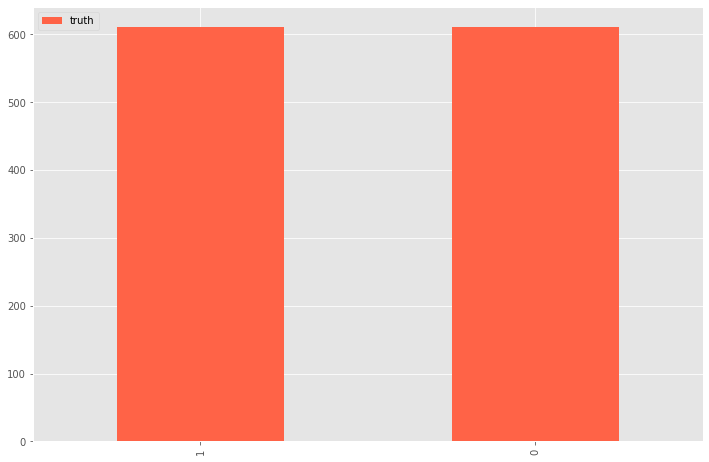

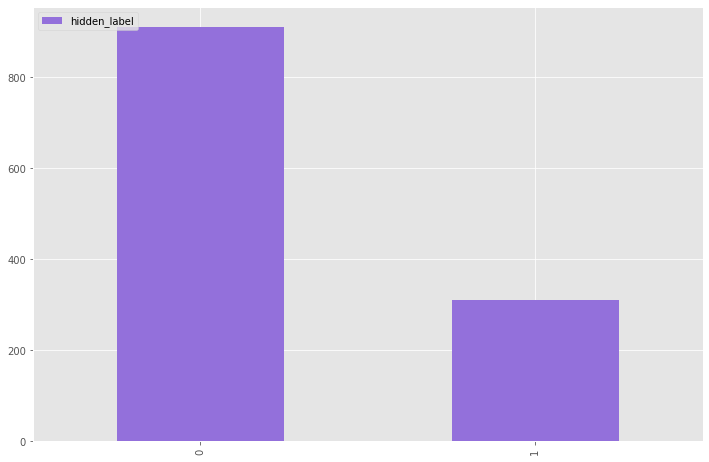

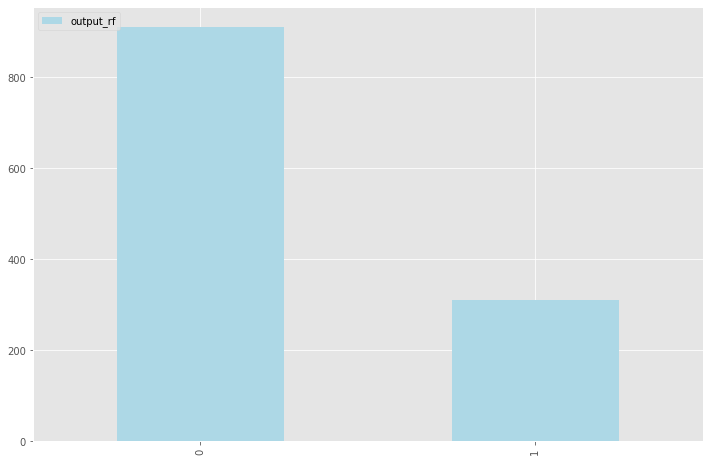

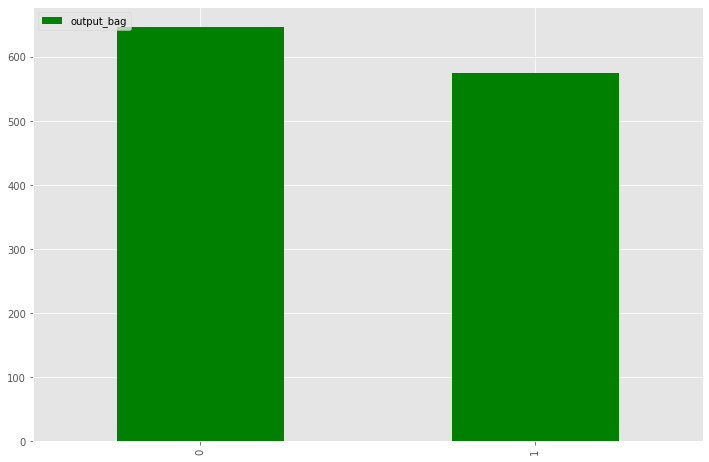

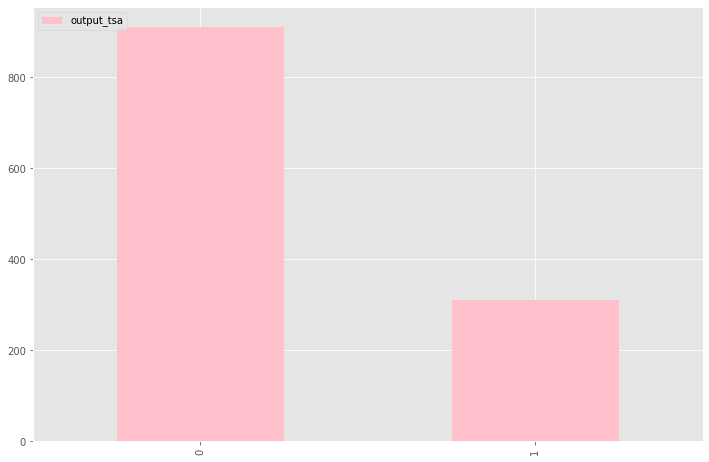

In [30]:
for col, rgb in zip(results.columns, ['tomato', 'mediumpurple', 'lightblue', 'green', 'pink']):
    plot_bar(results, col, rgb)